In [1]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [2]:
import pandas as pd

train = pd.read_csv('./input/fashion-mnist/fashion-mnist_train.csv')
test = pd.read_csv('./input/fashion-mnist/fashion-mnist_test.csv')

In [3]:
print(train.shape)
train.columns

(60000, 785)


Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)

In [4]:
print(test.shape)
test.columns

(10000, 785)


Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)

In [5]:
train.dtypes

label       int64
pixel1      int64
pixel2      int64
pixel3      int64
pixel4      int64
            ...  
pixel780    int64
pixel781    int64
pixel782    int64
pixel783    int64
pixel784    int64
Length: 785, dtype: object

In [6]:
df = train.copy()

train = df.sample(frac = 0.7, random_state = 0)
valid = df.drop(train.index)

print(train.shape)
print(valid.shape)

(42000, 785)
(18000, 785)


In [7]:
def split_Xy(df):
    X = df
    y = X.pop('label')
    return X, y

X_train, y_train = split_Xy(train)
print(X_train.shape, y_train.shape)

(42000, 784) (42000,)


In [8]:
X_valid , y_valid = split_Xy(valid)
print(X_valid.shape, y_valid.shape)

(18000, 784) (18000,)


In [9]:
X_test , y_test = split_Xy(test)
print(X_test.shape, y_test.shape)

(10000, 784) (10000,)


In [10]:
y_train.unique()

array([1, 6, 8, 7, 0, 5, 2, 9, 4, 3])

In [11]:
input_shape = [X_train.shape[1]]
print(input_shape)

[784]


In [12]:
import numpy as np

# https://numpy.org/doc/stable/reference/generated/numpy.reshape.html
img1 = np.reshape(list(X_train.iloc[0]), (28, 28))

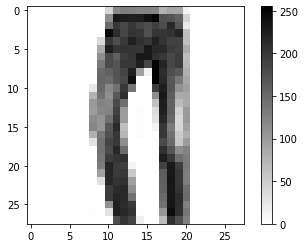

In [13]:
# https://www.tensorflow.org/tutorials/keras/classification
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img1, cmap = plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

# val: 0.852, test: 0.862
"""
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape= input_shape),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation = 'softmax')
])
"""

"\nmodel = tf.keras.Sequential([\n    tf.keras.layers.Flatten(input_shape= input_shape),\n    tf.keras.layers.Dense(128, activation='relu'),\n    tf.keras.layers.Dense(10, activation = 'softmax')\n])\n"

In [15]:
# val: 0.8287222385406494, test: 0.8965

model = keras.Sequential([
    layers.BatchNormalization(input_shape = input_shape),
    layers.Dense(512, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(10, activation = 'softmax'),
])

In [16]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    patience = 5,
    min_delta = 0.001,
    restore_best_weights = True,
)

In [17]:
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy
# https://stackoverflow.com/questions/34240703/what-are-logits-what-is-the-difference-between-softmax-and-softmax-cross-entrop

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              # If you don't use softmax for the last layer, you need to set from_logits as True
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data = (X_valid, y_valid),
    batch_size = 256,
    epochs = 500,
    callbacks = [early_stopping],
    verbose = 0,
)

In [18]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.616424,0.787405,0.422871,0.851556
1,0.433273,0.843810,0.363476,0.868389
2,0.375605,0.863214,0.344510,0.875222
3,0.355234,0.869262,0.333250,0.881556
4,0.336782,0.874833,0.338851,0.879556


0.30752870440483093


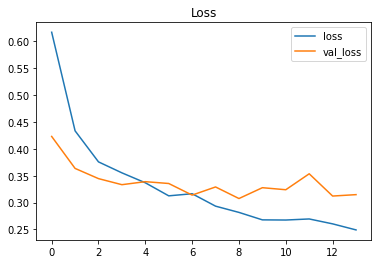

In [19]:
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss')
print(history_df.val_loss.min())

0.8914999961853027


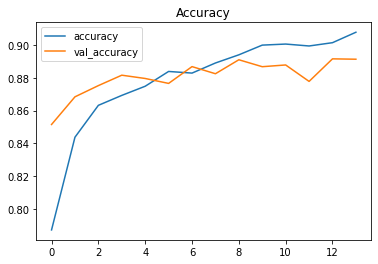

In [20]:
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy')
print(history_df.val_accuracy.max())

In [21]:
import numpy as np

predictions = model.predict(test)
print(predictions[0])
sum(predictions[0])

[8.6097133e-01 9.1057484e-07 8.2688441e-04 7.9999409e-05 8.7240129e-05
 1.0928179e-06 1.3795617e-01 2.3996046e-07 7.5647637e-05 5.0428582e-07]


1.000000023047562

In [22]:
pred_test = list(map(np.argmax, predictions))
pd.Series(pred_test[:5])

0    0
1    1
2    2
3    2
4    3
dtype: int64

In [23]:
y_test[:5]

0    0
1    1
2    2
3    2
4    3
Name: label, dtype: int64

In [24]:
(pd.Series(pred_test) == y_test).sum()/len(y_test)

0.8917

In [25]:
# https://www.tensorflow.org/tutorials/keras/classification#evaluate_accuracy

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}, Test accuracy: {test_acc}")

313/313 [==============================] - 0s 920us/step - loss: 0.3041 - accuracy: 0.8917
Test loss: 0.3041037321090698, Test accuracy: 0.891700029373169


# Reference

[Kaggle - Intro to Deep Learning - Dropout and Batch Normalization](https://www.kaggle.com/ryanholbrook/dropout-and-batch-normalization)

[Kaggle - Intro to Deep Learning - Binary Classification](https://www.kaggle.com/ryanholbrook/binary-classification)

[Tensorflow - Tutorial - Basic classification: Classify images of clothing](https://www.tensorflow.org/tutorials/keras/classification)

[UD187 - Lesson 3: Your First Model - Fashion MNIST](https://classroom.udacity.com/courses/ud187/lessons)